In [1]:
from StringIO import StringIO  # got moved around in python3 if you're using that.
import pandas as pd

import requests

url = 'https://docs.google.com/spreadsheets/d/1GMyNxouHqFscibUeUZFrZ3OLDmYV7Rafd1k5Y9P6Pc4/export?format=csv&id'
r = requests.get(url)
data = r.content
df = pd.read_csv(StringIO(data))

X = df.iloc[:,1:3]
y = df['category']

df.head()

C:\Users\David\Anaconda\lib\site-packages\requests\packages\urllib3\util\ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


,game,spatial,complexity,category
0,Cash N Guns,1,1,0
1,Lost Cities,2,5,0
2,Modern Art,1,5,0
3,Bottle Imp,8,4,0
4,Carcassonne,40,6,0


In [51]:
from seaborn import plt
%matplotlib inline
import numpy as np
from itertools import cycle
from matplotlib.colors import ListedColormap

def plot_surface(DF, ALGO, CAT_COL, **kwargs):
    fig = plt.figure(figsize=(15,12))
    cmap_bold = cycle('rgbyc')
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFFFE0', '#E0FFFF'
                                 #, '#F472D0'
                                ])
    
    try:
        cats = ALGO.n_clusters
    except:
        cats = len(DF[CAT_COL].unique())
    
    h = 0.2
    x_min, x_max, y_min, y_max = 0, 100, 0, 100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = ALGO.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    for i, c in zip(range(cats), cmap_bold):
        plt.scatter(DF.spatial[DF[CAT_COL] == i],
                    DF.complexity[DF[CAT_COL] == i],
                    c = c, label = i, **kwargs)
    
    for i, name in enumerate(DF.game):
        plt.annotate(name, (DF.iloc[i,1], DF.iloc[i,2]), **kwargs)
    
    plt.legend(title = 'Game Type')
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.xlabel('Spatial Component')
    plt.ylabel('Complexity') 
    
# This function plots the points and the decision surface generated by algorithm
# It takes a fitted model, a string depicting the name of column for category, and an int for number of categories
# Behavior is off if number of colors in cmaps is higher than n_neighbors/n_clusters

### Assume categories unknown, and we cluster

In [3]:
from sklearn.cluster import KMeans

ctr = KMeans(5)
ctr.fit(X)

cluster = pd.Series(ctr.labels_, name='cluster')
df2 = pd.concat([df, cluster], axis=1)
df2.head()

,game,spatial,complexity,category,cluster
0,Cash N Guns,1,1,0,1
1,Lost Cities,2,5,0,1
2,Modern Art,1,5,0,1
3,Bottle Imp,8,4,0,1
4,Carcassonne,40,6,0,0


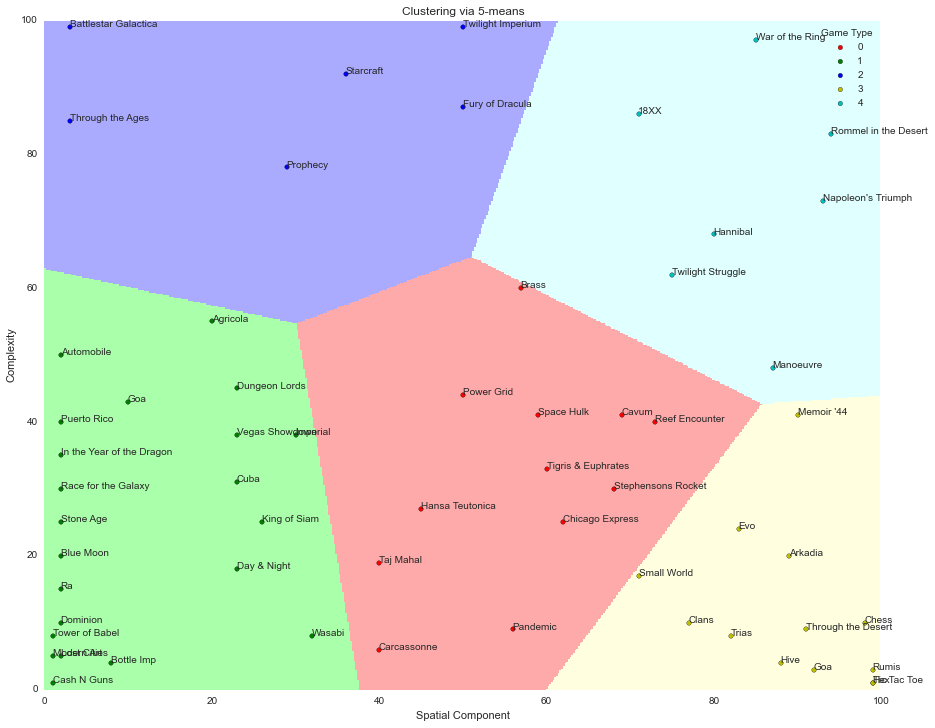

In [4]:
plot_surface(df2, ctr, 'cluster')
plt.title('Clustering via 5-means')

### Assume categories known, and we plot the decision boundaries

In [63]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
_, __, name_train, name_test = train_test_split(X, df.game, test_size=0.25, random_state=1)

test_df = pd.concat([pd.DataFrame(name_test, columns = ['game']), 
                     pd.DataFrame(X_test, columns = ['spatial', 'complexity']), 
                     pd.DataFrame(y_test, columns = ['category'])],
                    axis=1)

print X_train.shape, X_test.shape
test_df.game

(45L, 2L) (15L, 2L)


0     Stephensons Rocket
1         Reef Encounter
2             Modern Art
3                    Hex
4                  Rumis
5                  Trias
6      Twilight Imperium
7              Starcraft
8                  Cavum
9        Chicago Express
10       Hansa Teutonica
11                   Evo
12                   Goa
13            Bottle Imp
14              Pandemic
Name: game, dtype: object

In [64]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = range(1,11,2)

scores = []
for i in n_neighbors:
    clf_test = KNeighborsClassifier(i)
    clf_test.fit(X_train, y_train)
    scores.append(clf_test.score(X_test, y_test))

scores

[0.8666666666666667,
 0.8666666666666667,
 0.8666666666666667,
 0.73333333333333328,
 0.73333333333333328]

In [67]:
clf = KNeighborsClassifier(3)
clf.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=3, p=2, weights='uniform')

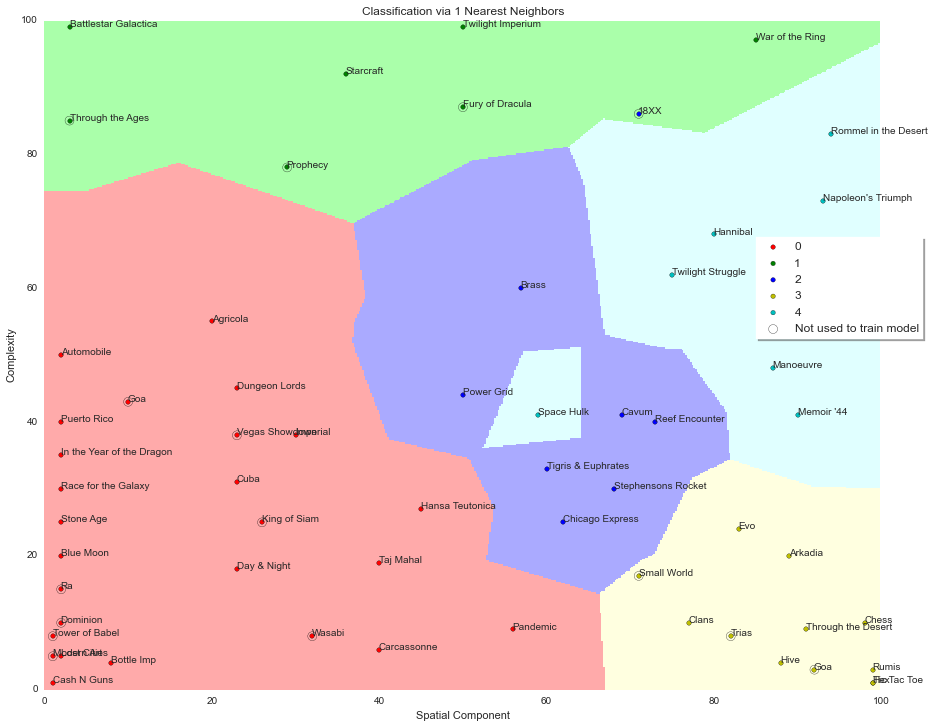

In [61]:
plot_surface(df, clf, 'category')

# The next line adds a gray halo to test points
plt.scatter(test_df.spatial, test_df.complexity, s=80, facecolors='none', label = 'Not used to train model')

leg = plt.legend(loc='center', shadow=True, fontsize='large', frameon=True, bbox_to_anchor=(.95,.6))
leg.get_frame().set_facecolor('w')

plt.title('Classification via {} Nearest Neighbors'.format(clf.n_neighbors), fontsize='large')

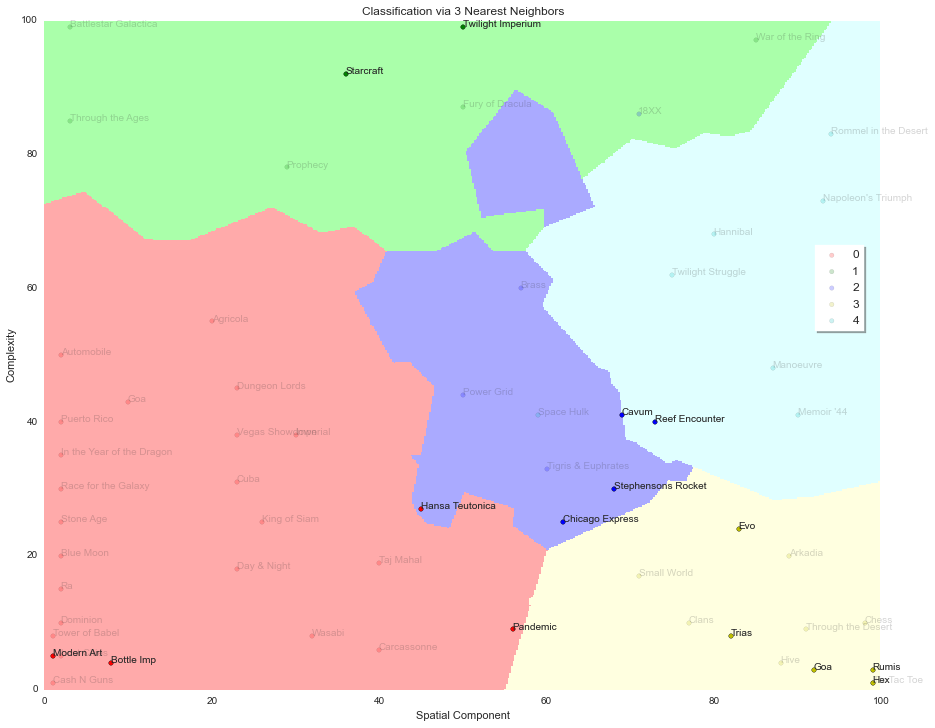

In [68]:
# This one plots the training data with low alpha, then overlays test points on top
plot_surface(df, clf, 'category', alpha=.2)

cmap_bold = cycle('rgbyc')
for i, c in zip(range(5), cmap_bold):
    plt.scatter(test_df.spatial[test_df.category == i],
                test_df.complexity[test_df.category == i],
                c = c)

for i, name in enumerate(test_df.game):
    plt.annotate(name, (test_df.iloc[i,1], test_df.iloc[i,2]))
    
leg = plt.legend(loc='center', shadow=True, fontsize='large', frameon=True, bbox_to_anchor=(.95,.6))
leg.get_frame().set_facecolor('w')

plt.title('Classification via {} Nearest Neighbors'.format(clf.n_neighbors), fontsize='large')